In [1]:
%run nlp_core.ipynb

Shape: (120000, 2)
Num classes: 4
Labels: [0, 1, 2, 3]


In [2]:
vocab, train_loader, val_loader, test_loader = prepare_core(
    train_csv_path="data/train.csv",
    test_csv_path="data/test.csv",
    val_size=0.1,
    max_vocab=30000,
    max_len=200,
    batch_size=64,
    seed=SEED
)

print("Vocab size:", len(vocab))
x, y, lengths = next(iter(train_loader))
print("x:", x.shape, "y:", y.shape, "lengths:", lengths.shape, "labels sample:", y[:10], "lengths sample:", lengths[:10])

Vocab size: 30000
x: torch.Size([64, 200]) y: torch.Size([64]) lengths: torch.Size([64]) labels sample: tensor([0, 2, 1, 2, 3, 2, 0, 2, 1, 2]) lengths sample: tensor([39, 37, 37, 39, 45, 50, 49, 49, 41, 33])


In [3]:
from torch.nn.utils.rnn import pack_padded_sequence
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=4, num_layers=1, dropout=0.2, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        emb = self.embedding(x)  

        packed = pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        _, h_n = self.rnn(packed)         
        last_hidden = h_n[-1]           

        last_hidden = self.dropout(last_hidden)
        logits = self.fc(last_hidden)
        return logits

In [4]:
rnn_model = RNNClassifier(
    vocab_size=len(vocab),
    embed_dim=128,
    hidden_dim=128,
    num_classes=4,
    num_layers=1,
    dropout=0.2,
    pad_idx=vocab[PAD_TOKEN]
)

rnn_model, rnn_history = train_model(
    rnn_model,
    train_loader,
    val_loader,
    epochs=6,
    lr=1e-3,
    device=device
)

Epoch 01 | train loss 0.8785 acc 0.6242 f1 0.6221 || val loss 0.7058 acc 0.7003 f1 0.6976
Epoch 02 | train loss 0.8100 acc 0.6640 f1 0.6596 || val loss 0.8067 acc 0.6673 f1 0.6634
Epoch 03 | train loss 0.7039 acc 0.7246 f1 0.7238 || val loss 0.8599 acc 0.6448 f1 0.6409
Epoch 04 | train loss 0.8081 acc 0.6650 f1 0.6624 || val loss 0.6857 acc 0.7678 f1 0.7657
Epoch 05 | train loss 0.6585 acc 0.7581 f1 0.7576 || val loss 0.8037 acc 0.6935 f1 0.6891
Epoch 06 | train loss 0.5974 acc 0.7900 f1 0.7895 || val loss 0.6183 acc 0.7841 f1 0.7831


In [5]:
test_loss, test_acc, test_f1 = run_epoch(rnn_model, test_loader, optimizer=None, device=device)
print(f"TEST | loss {test_loss:.4f} acc {test_acc:.4f} f1 {test_f1:.4f}")

TEST | loss 0.6374 acc 0.7787 f1 0.7775


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def get_preds(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y, lengths in loader:
            x, y, lengths = x.to(device), y.to(device), lengths.to(device)
            logits = model(x, lengths)
            preds = torch.argmax(logits, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

def plot_history(history, title_prefix=""):
    history = np.array(history, dtype=float)
    epochs = history[:, 0]
    tr_loss, tr_acc = history[:, 1], history[:, 2]
    va_loss, va_acc = history[:, 4], history[:, 5]

    plt.figure()
    plt.plot(epochs, tr_loss, color="blue")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title(f"{title_prefix} Train Loss")
    plt.show()

    plt.figure()
    plt.plot(epochs, tr_acc, color="blue")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Train Accuracy")
    plt.show()

    plt.figure()
    plt.plot(epochs, va_loss, color="blue")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title(f"{title_prefix} Validation Loss")
    plt.show()

    plt.figure()
    plt.plot(epochs, va_acc, color="blue")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Validation Accuracy")
    plt.show()

def full_evaluation(model, history, test_loader, device, name="Model"):
    test_loss, test_acc, test_f1 = run_epoch(model, test_loader, optimizer=None, device=device)
    print(f"{name} TEST | loss {test_loss:.4f} acc {test_acc:.4f} f1 {test_f1:.4f}")

    y_true, y_pred = get_preds(model, test_loader, device)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=2))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    plt.figure()
    disp.plot(values_format="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    plot_history(history, title_prefix=name)

RNN TEST | loss 0.6374 acc 0.7787 f1 0.7775

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.77      0.77      1900
           1       0.82      0.88      0.85      1900
           2       0.76      0.75      0.75      1900
           3       0.76      0.71      0.73      1900

    accuracy                           0.78      7600
   macro avg       0.78      0.78      0.78      7600
weighted avg       0.78      0.78      0.78      7600



<Figure size 640x480 with 0 Axes>

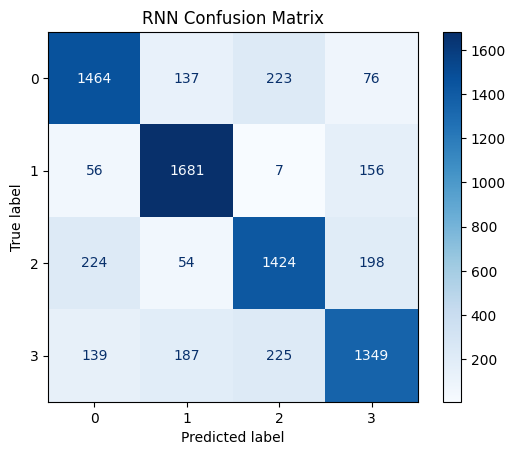

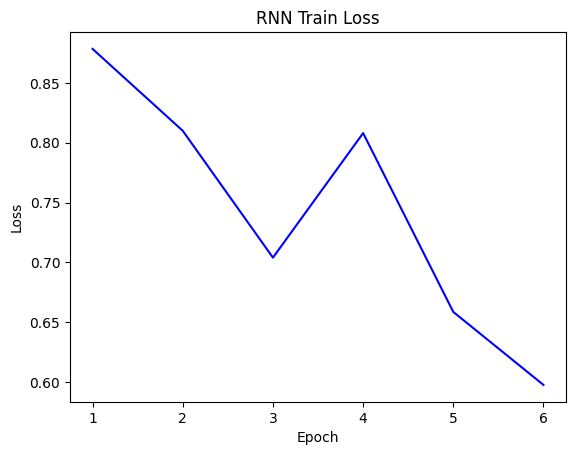

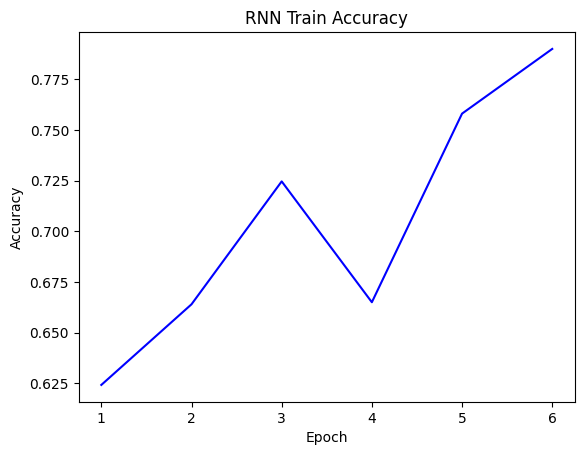

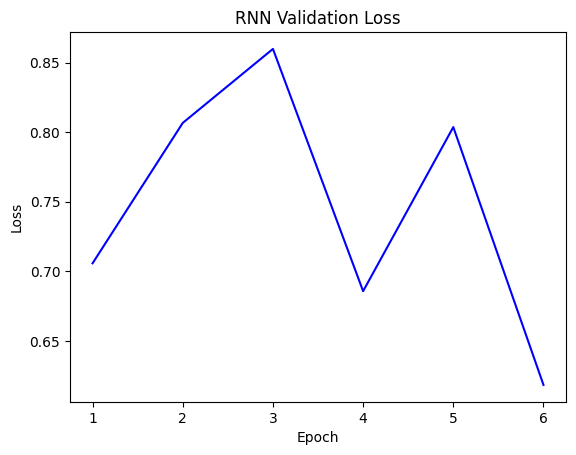

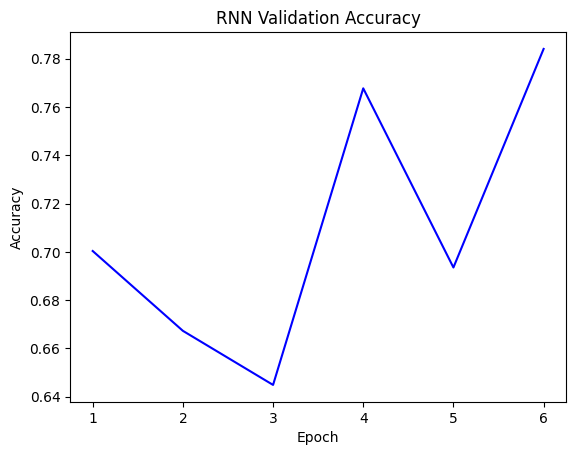

In [8]:
full_evaluation(rnn_model, rnn_history, test_loader, device, name="RNN")